# Reading SP Data

The Spectral Profiler data is available in archives with `.sl2` file endings.  These files are 

In [ ]:
import os
import tarfile
import glob

import plio
import libpysat

# from datasketch import MinHashLSH, WeightedMinHashGenerator
%pylab inline

## Data Extraction
Only the .spc file is truly needed here.  We want to keep a link to the underlying jpg, but those are simply the same file name with .jpg attched.  I also wonder how much value we have in keeping those around at all?  Something to decide in the future.

All of the data is currently stored locally in:  `/work/projects/jaxa02/SP_Level2C/02`

In [ ]:
files = glob.glob('*.sl2')
for f in files:
    tar = tarfile.open(f)
    # Extract the spc and the ctg files
    list(map(tar.extract, [m for m in tar.getmembers() if '.spc' in m.name]))
files = glob.glob('*.spc')

# If you want a csv/tsv file - this block cooks one - maybe good for loading into HBase
"""with open('data.tsv', 'w') as csv:
    for i, f in enumerate(files):
        s = libpysat.data.spectra.Spectra.from_file(f).T
        s['image_name'] = os.path.splitext(f)[0]
        header = True
        if i > 0:
            header = False
        s.to_csv(csv, mode='a', sep='\t', header=header)"""

## Extracting Continuum Corrected Spectra

In [ ]:
import os
files = glob.glob('*.spc')
d = {}
for f in files:
    s = libpysat.data.spectra.Spectra.from_file(f)
    ref1s = s.xs('REF1', level=1, axis=1)
    res, denom = ref1s.continuum_correct(nodes=[512.6, 1547.7, 2404.2],correction_nodes=[512.6, 1547.7, 2587.9], func=libpysat.transform.continuum.regression)
    d[s.loc['PRODUCT_ID'].iloc[0]] = res
    break
res

## Computing a Weighted MinHash

In [4]:
mg = WeightedMinHashGenerator(269, sample_size=256)
def compute_minhash(col, mg,**kwargs):
    v = col.values
    m = mg.minhash(v)
    return m

hashes = merged.data.apply(compute_minhash, args=(mg,))
print(len(hashes))

NameError: name 'merged' is not defined

## Creating the MinHashLSH index

In [292]:
# Create weighted MinHash LSH index
lsh = MinHashLSH(threshold=0.98, num_perm=256, prepickle=False)
for i, j in enumerate(hashes[:1000]):
    lsh.insert("{}".format(i), j)
result = lsh.query(hashes[11])
print("Approximate neighbours with weighted Jaccard similarity > 0.98", result)

Approximate neighbours with weighted Jaccard similarity > 0.98 ['128', '11', '7', '29', '12', '30', '451', '136']


## Sizes - Can we do this in memory?
How large are the has tables for the 1164 observations that have been loaded?

In [245]:
print(lsh.hashranges)
for ht in lsh.hashtables:
    k = list(ht.keys())[0]
    print(len(ht.keys()), sys.getsizeof(k))
sys.getsizeof(k)

[(0, 85), (85, 170), (170, 255)]
453 1393
457 1393
787 1393


1393

Sanity check to see that the above identified neighbors are actually similar.

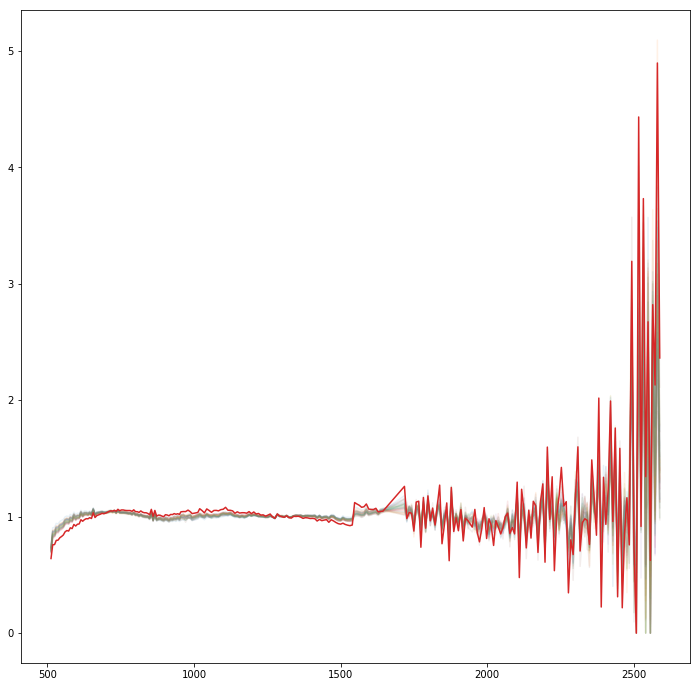

In [107]:
figsize(12,12)
for i in result:
    merged.data.T.iloc[int(i)].plot(alpha=0.1)
merged.data.T.iloc[200].plot()

In [131]:
from datasketch import WeightedMinHashLSH
# Create weighted MinHash LSH index
wlsh = WeightedMinHashLSH(threshold=0.965, num_perm=128, weights=(0.2, 0.8))
for i, j in enumerate(hashes):
    wlsh.insert("{}".format(i), j)
result = wlsh.query(hashes[11])
print("Approximate neighbours with weighted Jaccard similarity > 0.965", result)

Approximate neighbours with weighted Jaccard similarity > 0.965 ['0', '668', '238', '139', '1006', '22', '54', '480', '62', '467', '618', '1114', '30', '28', '36', '302', '1038', '1124', '49', '394', '133', '506', '299', '717', '7', '83', '221', '52', '255', '1005', '1039', '366', '617', '23', '487', '505', '939', '18', '12', '1081', '745', '1082', '1153', '26', '754', '807', '1128', '79', '627', '719', '776', '346', '758', '137', '21', '43', '11', '808', '663', '239', '252', '658', '562', '1104', '51', '303', '783', '287', '230', '490', '1015', '471', '192', '486', '626', '1018', '27', '662', '784', '122', '1046', '1091', '16', '157', '489', '1011', '437', '1129', '33', '130', '229', '744', '262', '46', '1072', '775', '416', '1048', '234', '29', '711', '1075', '243', '264', '47', '35', '395', '1125', '1001', '17']
